In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu
from matplotlib.pyplot import subplot_mosaic as mosaic
import matplotlib.transforms as mtransforms
import math
import matplotlib
import warnings
from IPython.display import Image, display
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")

### Quality control of sex annotations

Output of QC with modmatcher from modmatcher_QC.R can be found in the subdirectory /modmatcher. Workflow taken from https://rpubs.com/seungyeul/471026

In [2]:
# list genes (ensembl ids) that were used as sex markers in MODMatcher paper (pmid 25122495)
genes = ['ENSG00000129824', 'ENSG00000067048']
ct_sels_init = ['BRCA', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD']

In [3]:
def align(pheno, expr):
    keep = pheno.index.isin(expr.index)
    pheno = pheno[keep]
    pheno = pheno[pheno.index.isin(expr.index)]
    samples = pheno.index            
    expr = expr.loc[samples]
    expr = expr.loc[:, (expr.std() != 0)]
    pheno = pheno[pheno.index.isin(expr.index)]
    return pheno, expr

def get_expression_data(cohort):
    try:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.htseq_fpkm.tsv'), sep='\t', header=0, index_col=0)
    except:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'brca_metabric.tsv'), sep='\t', header=0, index_col=0)
    expression_data.columns = expression_data.columns.str.split('.').str[0].tolist()
    return expression_data

def get_pheno_data(cohort):
    try:
        tissue_type_field, tissue_type = 'sample_type.samples', 'Primary Tumor'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.GDC_phenotype.tsv'), sep='\t', header=0, index_col='submitter_id.samples')
    except:
        tissue_type_field, tissue_type = 'Sample Type', 'Primary'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'metabric_brca_pheno.tsv'), sep='\t', header=0, index_col=0)
    assert len(pheno_data.iloc[0]) == len(pheno_data.iloc[0].values)
    pheno_data['cohort'] = str(cohort)
    pheno_data =  pheno_data[pheno_data[tissue_type_field] == tissue_type]
    return pheno_data

### Computation of possible mismatches based on euclidean distance of sample-specific values for ENSG00000129824 and ENSG00000067048 from cohort-specific means for ENSG00000129824 and ENSG00000067048, for male and female cohorts

BRCA
Not well separated in ENSG00000129824: 0
Not well separated in ENSG00000067048: 0


COAD
Not well separated in ENSG00000129824: 37
Not well separated in ENSG00000067048: 34


GBM
Not well separated in ENSG00000129824: 0
Not well separated in ENSG00000067048: 0


HNSC
Not well separated in ENSG00000129824: 30
Not well separated in ENSG00000067048: 77


KIRC
Not well separated in ENSG00000129824: 11
Not well separated in ENSG00000067048: 25


KIRP
Not well separated in ENSG00000129824: 27
Not well separated in ENSG00000067048: 72


LUSC
Not well separated in ENSG00000129824: 23
Not well separated in ENSG00000067048: 74


PCPG
Not well separated in ENSG00000129824: 1
Not well separated in ENSG00000067048: 2


READ
Not well separated in ENSG00000129824: 10
Not well separated in ENSG00000067048: 14


STAD
Not well separated in ENSG00000129824: 18
Not well separated in ENSG00000067048: 27




"\nhandles, labels = axs2[0, 0].get_legend_handles_labels()\nfig2.legend(handles, labels, loc='lower right')\n#fig2.subplots_adjust(right=0.85)\n\nhandles, labels = axs[0, 0].get_legend_handles_labels()\nfig.legend(handles, labels, loc='lower right')\n#fig.subplots_adjust(right=0.85)\n\nhandles, labels = axs3[0, 0].get_legend_handles_labels()\nfig3.legend(handles, labels, loc='lower right')\n"

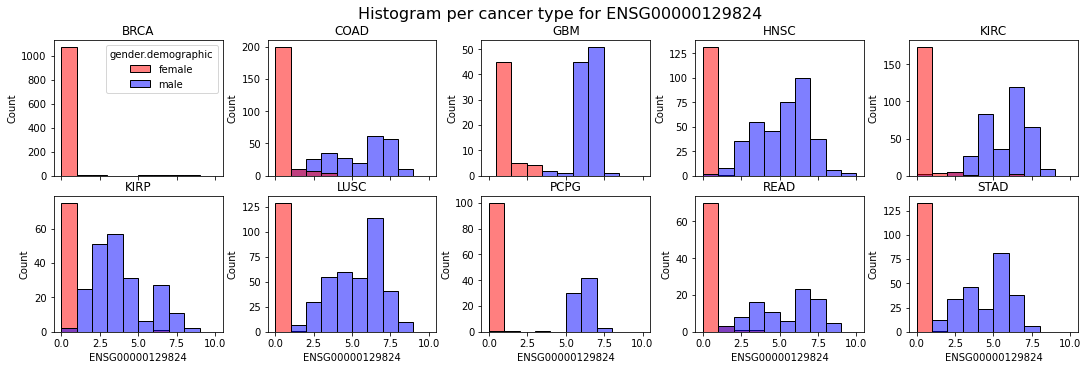

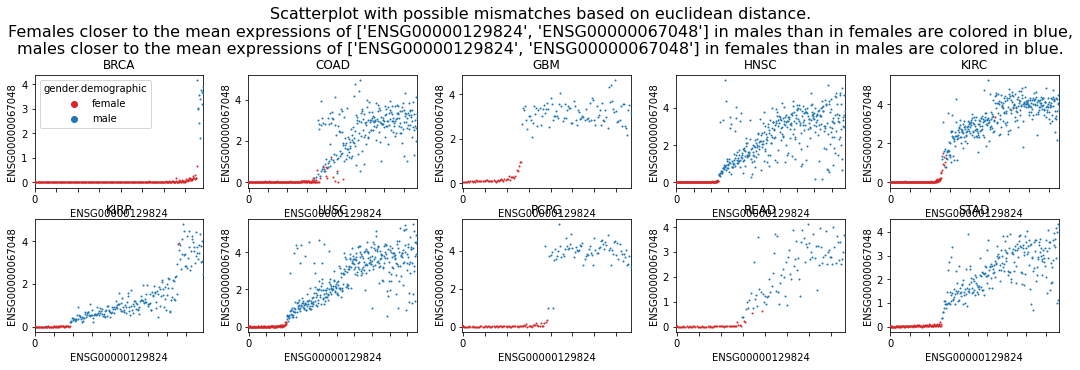

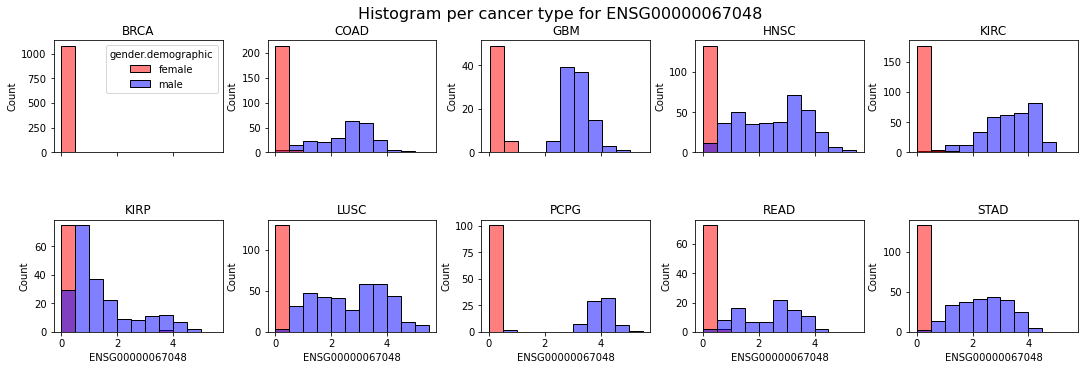

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(15,5), sharex=True, sharey=False)
fig.suptitle(f'Histogram per cancer type for {genes[0]}', fontsize=16)
fig.tight_layout()
fig2, axs2 = plt.subplots(2, 5, figsize=(15,5), sharex=False, sharey=False)
fig2.suptitle(f'Scatterplot with possible mismatches based on euclidean distance.\nFemales closer to the mean expressions of {genes} in males than in females are colored in blue,\nmales closer to the mean expressions of {genes} in females than in males are colored in blue.', fontsize=16)
fig2.tight_layout()
fig3, axs3 = plt.subplots(2, 5, figsize=(15,5), sharex=True, sharey=False)
fig3.suptitle(f'Histogram per cancer type for {genes[1]}', fontsize=16)
fig3.tight_layout()
plt.subplots_adjust(hspace=0.6)

i = j = 0
for cohort in ct_sels_init:
    print(cohort)
    """
    # read single data
    expr = get_expression_data(cohort)
    pheno = get_pheno_data(cohort)
    # align pheno and expr
    pheno, expr = align(pheno, expr)
    expr = expr[genes]
    pheno = pheno[pheno['gender.demographic'].notna()]
    pheno_data = pheno[pheno['gender.demographic'] != 'not reported']
    expr = pd.merge(expr, pheno['gender.demographic'], left_index=True, right_index=True)
    expr.to_csv(os.path.join(os.getcwd(), 'modmatcher_data', f'{cohort}_merged.csv'))
    """
    
    expr = pd.read_csv(os.path.join(os.getcwd(), 'modmatcher_data', f'{cohort}_merged.csv'), index_col='submitter_id.samples', header=0)
                       
    palette = {'female': 'red', 'male': 'blue'}
    sns.histplot(expr, x=genes[0], ax=axs[j,i], hue='gender.demographic', kde=False, legend=(i==j==0), binwidth=1, palette=palette)
    axs[j,i].title.set_text(cohort)
    
    mean_m = expr[expr['gender.demographic'] == 'male'][genes[0]].mean()
    mean_f = expr[expr['gender.demographic'] == 'female'][genes[0]].mean()
    expr['dist_f_0'] = expr.apply(lambda x: abs(np.array(x[genes[0]]) - mean_f), axis=1)
    expr['dist_m_0'] = expr.apply(lambda x: abs(np.array(x[genes[0]]) - mean_m), axis=1)
    expr['mismatch_0'] = ((expr['dist_m_0']<expr['dist_f_0']) & (expr['gender.demographic'] == 'female')) | ((expr['dist_f_0']<expr['dist_m_0']) & (expr['gender.demographic'] == 'male'))
    print(f'Not well separated in {genes[0]}: ' + str(len(expr[expr['mismatch_0']])))
    
    sns.histplot(expr, x=genes[1], ax=axs3[j,i], hue='gender.demographic', kde=False, legend=(i==j==0), binwidth=0.5, palette=palette)
    axs3[j,i].title.set_text(cohort)
    mean_m = expr[expr['gender.demographic'] == 'male'][genes[1]].mean()
    mean_f = expr[expr['gender.demographic'] == 'female'][genes[1]].mean()
    expr['dist_f_1'] = expr.apply(lambda x: abs(np.array(x[genes[1]]) - mean_f), axis=1)
    expr['dist_m_1'] = expr.apply(lambda x: abs(np.array(x[genes[1]]) - mean_m), axis=1)
    expr['mismatch_1'] = ((expr['dist_m_1']<expr['dist_f_1']) & (expr['gender.demographic'] == 'female')) | ((expr['dist_f_1']<expr['dist_m_1']) & (expr['gender.demographic'] == 'male'))
    print(f'Not well separated in {genes[1]}: ' + str(len(expr[expr['mismatch_1']])))
            
    palette = {'female': 'tab:red', 'male': 'tab:blue'}
    sns.swarmplot(expr, x=genes[0], y=genes[1], ax=axs2[j,i], hue='gender.demographic', palette=palette, size=2, legend=(i==j==0))
    axs2[j,i].title.set_text(cohort)
    
    axs2[j,i].set_xticks(range(9))
    axs2[j,i].set_xticklabels(range(9))

    axs2[j,i].xaxis.set_major_locator(MaxNLocator(integer=True))  
    
    i += 1
    if i == 5:
        i = 0
        j += 1
    print('\n')

"""
handles, labels = axs2[0, 0].get_legend_handles_labels()
fig2.legend(handles, labels, loc='lower right')
#fig2.subplots_adjust(right=0.85)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
#fig.subplots_adjust(right=0.85)

handles, labels = axs3[0, 0].get_legend_handles_labels()
fig3.legend(handles, labels, loc='lower right')
"""
        

In [5]:
fig.savefig('histogram_RPS4Y1.pdf')
fig2.savefig('scatterplots2.pdf')
fig3.savefig('histogram_DDX3Y.pdf')

In [6]:
# TODO Legenden hinzufügen